<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/bert_AGnews_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [57]:
# 导入现成的分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [58]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [59]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['test.csv', 'classes.txt', 'train.csv', 'readme.txt']

In [60]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
# num = 10000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
# train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
# test = test.sample(n=1000)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

120000
   0  ...                                                  2
0  3  ...  Reuters - Short-sellers, Wall Street's dwindli...
1  3  ...  Reuters - Private investment firm Carlyle Grou...
2  3  ...  Reuters - Soaring crude prices plus worries\ab...
3  3  ...  Reuters - Authorities have halted oil export\f...
4  3  ...  AFP - Tearaway world oil prices, toppling reco...

[5 rows x 3 columns]
7600
   0  ...                                                  2
0  3  ...  Unions representing workers at Turner   Newall...
1  4  ...  SPACE.com - TORONTO, Canada -- A second\team o...
2  4  ...  AP - A company founded by a chemistry research...
3  4  ...  AP - It's barely dawn when Mike Fitzpatrick st...
4  4  ...  AP - Southern California's smog-fighting agenc...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [61]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 128
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [62]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [63]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101 26665  1011  2460  1011 19041  1010  2813  2395  1005  1055  1040
 11101  2989  1032  2316  1997 11087  1011 22330  8713  2015  1010  2024
  3773  2665  2153  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [64]:
# 训练参数
hidden_size=128
epochs = 5
batch_size = 256
validation_rate = 0.1

In [65]:
# 模型放在这里
# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4) # 分类类别数
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
# model.summary()
# model.config

In [66]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, hidden_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         3906816   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,009,892
Trainable params: 4,009,892
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [68]:
optimizer_c = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss_c = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_c = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_compare.compile(optimizer=optimizer_c, loss=loss_c, metrics=[metric_c])

In [69]:
# history是按照一个epoch记录一次，间隔太大了，所以手动重写一个基于batch的
class BatchCallback(tf.keras.callbacks.History):
  def __init__(self):
    self.batch = []
    self.history = {'loss':[], 'accuracy':[]}
  def on_train_batch_end(self, batch, logs=None):
    self.batch.append(batch)
    for k, v in logs.items():
      self.history[k].append(v)

In [70]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

Epoch 1/5
469/469 [==============================] - 190s 405ms/step - loss: 0.7227 - accuracy: 0.6953
Epoch 2/5
469/469 [==============================] - 190s 405ms/step - loss: 0.3373 - accuracy: 0.8896
Epoch 3/5
469/469 [==============================] - 190s 405ms/step - loss: 0.2682 - accuracy: 0.9123
Epoch 4/5
469/469 [==============================] - 190s 405ms/step - loss: 0.2255 - accuracy: 0.9262
Epoch 5/5
469/469 [==============================] - 190s 405ms/step - loss: 0.1963 - accuracy: 0.9355


In [71]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=[BatchCallback()],
    shuffle=True
)

Epoch 1/5
469/469 [==============================] - 31s 65ms/step - loss: 1.0890 - accuracy: 0.5335
Epoch 2/5
469/469 [==============================] - 30s 65ms/step - loss: 0.5726 - accuracy: 0.8100
Epoch 3/5
469/469 [==============================] - 32s 69ms/step - loss: 0.3591 - accuracy: 0.8833
Epoch 4/5
469/469 [==============================] - 32s 69ms/step - loss: 0.2963 - accuracy: 0.9039
Epoch 5/5
469/469 [==============================] - 32s 69ms/step - loss: 0.2573 - accuracy: 0.9165


In [72]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

30/30 [==============================] - 4s 136ms/step - loss: 0.3603 - accuracy: 0.8887


[0.360280305147171, 0.8886842131614685]

In [73]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

30/30 [==============================] - 0s 11ms/step - loss: 0.3401 - accuracy: 0.8837


[0.3400826156139374, 0.8836842179298401]

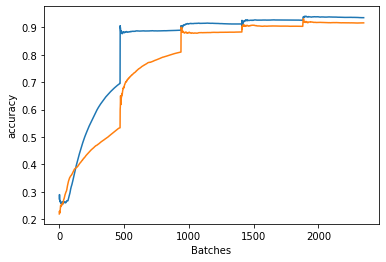

In [74]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [75]:
index = None
for idx, layer in enumerate(model_compare.layers):
  print(idx, layer.name)

0 embedding_1
1 bidirectional_1
2 dense_2
3 dense_3


In [76]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
# 用index更好
embedding_compare = model_compare.get_layer(index=0)

In [77]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = embedding_compare(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
  embs_list.append(embs)
embs = embedding_compare(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
embs_list.append(embs)
seq_embs_compare = tf.concat(embs_list, 0).numpy()
class_embedding_compare = np.zeros([4,hidden_size])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs_compare[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,hidden_size,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [hidden_size]).numpy()
print(class_embedding_compare)

[[-2.23944802e-02  1.55875282e-02  1.21596660e-02 -3.15808281e-02
  -3.28427143e-02  2.61176620e-02 -3.89238559e-02 -7.11645558e-03
  -2.34802067e-02  9.53746773e-03  5.18480921e-03 -1.47409579e-02
  -2.55397167e-02  8.03089514e-03  2.57486571e-02 -2.73762569e-02
  -9.28882335e-04 -8.99373740e-03 -6.15997519e-03  6.56104600e-03
   2.43420955e-02 -3.24684270e-02 -1.28460294e-02 -1.97299663e-02
  -1.08695235e-02 -4.21938300e-02  1.10258488e-02 -9.76384245e-03
  -8.45185947e-03  1.70575753e-02 -3.85858715e-02  3.33712175e-02
  -1.96247231e-02 -1.23317372e-02  4.87266015e-03 -4.06951867e-02
   9.05792415e-03  3.04197501e-02 -3.82473432e-02  1.82001870e-02
  -3.90603929e-03 -8.31801258e-03 -2.91324337e-03 -3.09233703e-02
  -3.21142934e-02 -1.83480512e-02 -4.99545968e-05 -3.43439616e-02
  -1.87686421e-02  2.88517270e-02  3.40804495e-02  1.19396485e-02
  -6.70464709e-03 -1.91056635e-02  4.67775622e-03 -2.65950169e-02
   5.25851781e-03  3.03695612e-02  1.35902371e-02 -2.82795187e-02
  -3.33557

In [78]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [79]:
# 得到每个类的embedding
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = get_embedding(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
  embs_list.append(embs)
embs = get_embedding(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
embs_list.append(embs)
seq_embs = tf.concat(embs_list, 0).numpy()
print(seq_embs)
class_embedding = np.zeros([4,hidden_size])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,hidden_size,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [hidden_size]).numpy()
print(class_embedding)

[[ 0.02465195  0.0001303  -0.01144493 ...  0.01478226  0.00657127
  -0.01122703]
 [ 0.02552237  0.00114205 -0.01447273 ...  0.01532164  0.00749414
  -0.01210248]
 [ 0.02554015  0.00171474 -0.01356095 ...  0.01733969  0.00670731
  -0.01252225]
 ...
 [ 0.02528451 -0.00108633 -0.01476502 ...  0.01496193  0.00748859
  -0.01393971]
 [ 0.01910484 -0.00278094 -0.00929833 ...  0.01124276  0.0077898
  -0.0096012 ]
 [ 0.02277888 -0.00093959 -0.01555616 ...  0.01374221  0.00647115
  -0.01314489]]
[[ 2.56577507e-02 -5.68271535e-05 -1.35721657e-02 -4.41314565e-04
  -2.24081753e-03 -4.52984031e-03 -4.41692490e-03 -2.22518612e-02
   1.10319294e-02 -9.54724569e-03  1.71730015e-03  1.38823222e-03
  -3.15365791e-02  8.26407969e-03  1.30967246e-02  1.73370503e-02
   1.20112468e-02  4.52315900e-03 -2.37359684e-02 -1.54401106e-03
  -8.85453046e-05  2.39457060e-02  1.47786792e-02  1.13398768e-03
  -5.88004943e-04  5.22184186e-04  5.37903095e-03  6.12324104e-03
   6.21248968e-03 -5.52571658e-03  1.11662773e-

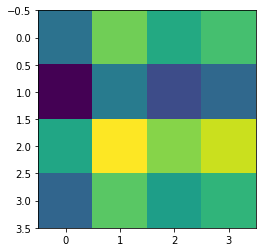

In [86]:
# 类表征的余弦相似性
res = sklearn.metrics.pairwise.cosine_similarity(class_embedding, class_embedding_compare)
plt.imshow(res)
plt.show()

In [87]:
# t-SNE分析,画图
def plot_scatter(emb, c_emb, y_label, flag):
  t_sne_temp = TSNE(n_components=2).fit_transform(np.concatenate((c_emb, emb)))
  t_sne_c = t_sne_temp[0:4,:]
  t_sne_temp = t_sne_temp[4:,:]
  y_label = [x + 10 * flag for x in y_label]
  plt.scatter(t_sne_temp[:,0], t_sne_temp[:,1], c=y_label, marker='o')
  plt.scatter(t_sne_c[:,0], t_sne_c[:,1], c='red', marker='D')

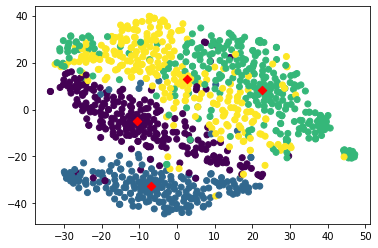

In [88]:
y_label = train_labels[10000:11000].numpy().tolist()
plot_scatter(seq_embs[10000:11000], class_embedding, y_label, 0)
plt.show()

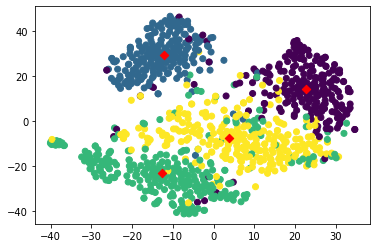

In [89]:
plot_scatter(seq_embs_compare[10000:11000], class_embedding_compare, y_label, 1)
plt.show()

In [90]:
def plot_graphs(history1, history2, history3, metric, labels):
  plt.plot(history1.history[metric], label=labels[0])
  plt.plot(history2.history[metric], label=labels[1])
  plt.plot(history3.history[metric], label=labels[2])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.legend()
  plt.show()

Epoch 1/5
469/469 [==============================] - 190s 405ms/step - loss: 0.4997 - accuracy: 0.8132
Epoch 2/5
469/469 [==============================] - 190s 406ms/step - loss: 0.2749 - accuracy: 0.9080
Epoch 3/5
469/469 [==============================] - 190s 406ms/step - loss: 0.2110 - accuracy: 0.9306
Epoch 4/5
469/469 [==============================] - 190s 406ms/step - loss: 0.1703 - accuracy: 0.9445
Epoch 5/5
469/469 [==============================] - 190s 406ms/step - loss: 0.1400 - accuracy: 0.9547
Epoch 1/5
469/469 [==============================] - 190s 406ms/step - loss: 1.3837 - accuracy: 0.2863
Epoch 2/5
469/469 [==============================] - 190s 405ms/step - loss: 1.0744 - accuracy: 0.4979
Epoch 3/5
469/469 [==============================] - 190s 406ms/step - loss: 0.9315 - accuracy: 0.5576
Epoch 4/5
469/469 [==============================] - 190s 406ms/step - loss: 0.7644 - accuracy: 0.7193
Epoch 5/5
469/469 [==============================] - 191s 406ms/step - lo

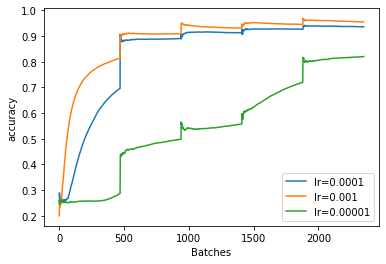

In [91]:
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['lr=0.0001','lr=0.001','lr=0.00001'])

Epoch 1/5
469/469 [==============================] - 130s 277ms/step - loss: 0.7812 - accuracy: 0.6499
Epoch 2/5
469/469 [==============================] - 130s 278ms/step - loss: 0.3573 - accuracy: 0.8846
Epoch 3/5
469/469 [==============================] - 130s 278ms/step - loss: 0.2761 - accuracy: 0.9105
Epoch 4/5
469/469 [==============================] - 130s 278ms/step - loss: 0.2293 - accuracy: 0.9252
Epoch 5/5
469/469 [==============================] - 131s 279ms/step - loss: 0.1964 - accuracy: 0.9365
Epoch 1/5
469/469 [==============================] - 252s 538ms/step - loss: 0.7180 - accuracy: 0.7082
Epoch 2/5
469/469 [==============================] - 252s 537ms/step - loss: 0.3451 - accuracy: 0.8887
Epoch 3/5
469/469 [==============================] - 252s 537ms/step - loss: 0.2724 - accuracy: 0.9116
Epoch 4/5
469/469 [==============================] - 252s 537ms/step - loss: 0.2306 - accuracy: 0.9257
Epoch 5/5
469/469 [==============================] - 252s 537ms/step - lo

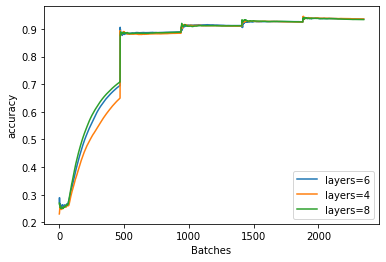

In [92]:
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=4, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=8, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['layers=6','layers=4','layers=8'])

Epoch 1/5
469/469 [==============================] - 172s 366ms/step - loss: 0.8368 - accuracy: 0.6248
Epoch 2/5
469/469 [==============================] - 172s 366ms/step - loss: 0.3402 - accuracy: 0.8874
Epoch 3/5
469/469 [==============================] - 172s 366ms/step - loss: 0.2595 - accuracy: 0.9149
Epoch 4/5
469/469 [==============================] - 172s 366ms/step - loss: 0.2155 - accuracy: 0.9294
Epoch 5/5
469/469 [==============================] - 172s 366ms/step - loss: 0.1855 - accuracy: 0.9392
Epoch 1/5
469/469 [==============================] - 229s 489ms/step - loss: 0.7552 - accuracy: 0.6787
Epoch 2/5
469/469 [==============================] - 229s 489ms/step - loss: 0.3055 - accuracy: 0.8996
Epoch 3/5
469/469 [==============================] - 229s 489ms/step - loss: 0.2430 - accuracy: 0.9205
Epoch 4/5
469/469 [==============================] - 229s 488ms/step - loss: 0.2038 - accuracy: 0.9330
Epoch 5/5
469/469 [==============================] - 229s 488ms/step - lo

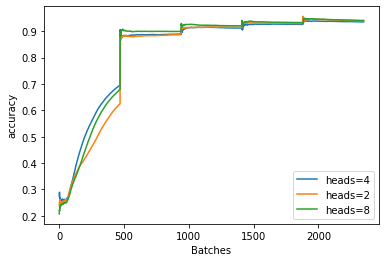

In [96]:
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=2, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=8, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['heads=4','heads=2','heads=8'])

Epoch 1/5
469/469 [==============================] - 151s 322ms/step - loss: 0.9564 - accuracy: 0.5490
Epoch 2/5
469/469 [==============================] - 152s 325ms/step - loss: 0.4460 - accuracy: 0.8547
Epoch 3/5
469/469 [==============================] - 152s 325ms/step - loss: 0.3266 - accuracy: 0.8967
Epoch 4/5
469/469 [==============================] - 152s 325ms/step - loss: 0.2790 - accuracy: 0.9122
Epoch 5/5
469/469 [==============================] - 152s 325ms/step - loss: 0.2454 - accuracy: 0.9226
Epoch 1/5
469/469 [==============================] - 288s 614ms/step - loss: 0.5743 - accuracy: 0.7669
Epoch 2/5
469/469 [==============================] - 288s 613ms/step - loss: 0.2738 - accuracy: 0.9089
Epoch 3/5
469/469 [==============================] - 288s 614ms/step - loss: 0.2201 - accuracy: 0.9261
Epoch 4/5
469/469 [==============================] - 288s 614ms/step - loss: 0.1858 - accuracy: 0.9372
Epoch 5/5
469/469 [==============================] - 288s 614ms/step - lo

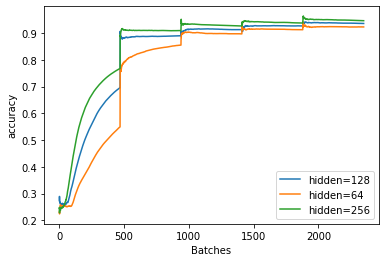

In [97]:
cnfg = BertConfig(hidden_size=64, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=256, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=1024)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['hidden=128','hidden=64','hidden=256'])